# Using the WFPT Class Factory

We have designed HSSM to be flexible. The users can use arbitrary log-likelihood functions that take arbitrary numbers of parameters with HSSM. The functions do not have to be LANs. Nor do they have to be differentiable (although differentiable likelihood functions are desirable for use with NUTS samplers). This notebook demonstrates how to use the WFPT class factories to generate arbitrary `pm.Distribution` classes for use with either PyMC or Bambi.

In [2]:
%cd /Users/aomar7/PycharmProjects/HSSM_updated/src

/Users/aomar7/PycharmProjects/HSSM_updated/src


In [12]:
import multiprocessing as mp

import bambi as bmb
import pandas as pd
import pytensor
import pytensor.tensor as at
import arviz as az
import jax
import numpy as np
import numpyro
import pymc as pm
from pymc import sampling_jax

# WFPT and LAN are two factory classes
from hssm.wfpt import WFPT, LAN
import ssms.basic_simulators

numpyro.set_host_device_count(jax.local_device_count())

In [4]:
print(pm.__version__)

5.0.1


In [5]:
#!pip install pymc

## Using Base WFPT class 

In [39]:
WFPT_base = WFPT.make_ssm_distribution(
    model="base",
    list_params=["v", "a", "z", "t", "theta"],
)

In [40]:
# Simulate some data
v_true, a_true, z_true, t_true, sv_true = [0.5, 1.5, 0.5, 0.5, 0.3]
obs_angle = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true, sv_true], model="ddm", n_samples=1000
)
obs = obs_angle["rts"][:, 0] * obs_angle["choices"][:, 0]

In [41]:
WFPTLikelihood = bmb.Likelihood(
    "WFPT", params=["v", "a", "z", "t", "theta"], parent="v", dist=WFPT_base
)
# You don't need to pass the link function for all the parameters when it's a non-distributional model.
# But if you want to use predictor for that parameter, you do need a link function
WFPTFamily = bmb.Family(
    "WFPT",
    likelihood=WFPTLikelihood,
    link={
        "v": "identity",
        "a": "identity",
        "z": "identity",
        "t": "identity",
        "theta": "identity",
    },
)
priors = {
    "Intercept": bmb.Prior("Uniform", lower=-3, upper=3, initval=0),
    "a": bmb.Prior("Uniform", lower=0.5, upper=5, initval=2),
    "z": bmb.Prior("Uniform", lower=0.1, upper=0.9, initval=0.5),
    "t": bmb.Prior("Uniform", lower=0, upper=1.9, initval=0.01),
    "theta": bmb.Prior("Uniform", lower=0, upper=1.9, initval=0.01),
}
df = pd.DataFrame(obs)
df.columns = ["rt"]
bmb_ddm = bmb.Model("rt ~ 1", df, family=WFPTFamily, priors=priors)
bmb_ddm

       Formula: rt ~ 1
        Family: WFPT
          Link: v = identity
  Observations: 1000
        Priors: 
    target = v
        Common-level effects
            Intercept ~ Uniform(lower: -3.0, upper: 3.0, initval: 0.0)
        
        Auxiliary parameters
            rt_theta ~ Uniform(lower: 0.0, upper: 1.899999976158142, initval: 0.009999999776482582)
            rt_a ~ Uniform(lower: 0.5, upper: 5.0, initval: 2.0)
            rt_t ~ Uniform(lower: 0.0, upper: 1.899999976158142, initval: 0.009999999776482582)
            rt_z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421, initval: 0.5)

In [42]:
pytensor.config.floatX = "float32"

idata_bmb_ddm = bmb_ddm.fit(
    chains=2, draws=500, tune=500, mp_ctx=mp.get_context("fork")
)

In [55]:
az.summary(idata_bmb_ddm)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rt_theta,0.676,0.001,0.674,0.677,0.000,0.000,874.0,631.0,1.0
rt_a,0.502,0.002,0.500,0.506,0.000,0.000,743.0,476.0,1.0
rt_t,0.496,0.010,0.478,0.515,0.000,0.000,1067.0,638.0,1.0
rt_z,0.900,0.000,0.900,0.900,0.000,0.000,507.0,380.0,1.0
Intercept,0.196,0.031,0.136,0.255,0.001,0.001,766.0,486.0,1.0


array([[<AxesSubplot: title={'center': 'rt_theta'}>,
        <AxesSubplot: title={'center': 'rt_theta'}>],
       [<AxesSubplot: title={'center': 'rt_a'}>,
        <AxesSubplot: title={'center': 'rt_a'}>],
       [<AxesSubplot: title={'center': 'rt_t'}>,
        <AxesSubplot: title={'center': 'rt_t'}>],
       [<AxesSubplot: title={'center': 'rt_z'}>,
        <AxesSubplot: title={'center': 'rt_z'}>],
       [<AxesSubplot: title={'center': 'Intercept'}>,
        <AxesSubplot: title={'center': 'Intercept'}>]], dtype=object)

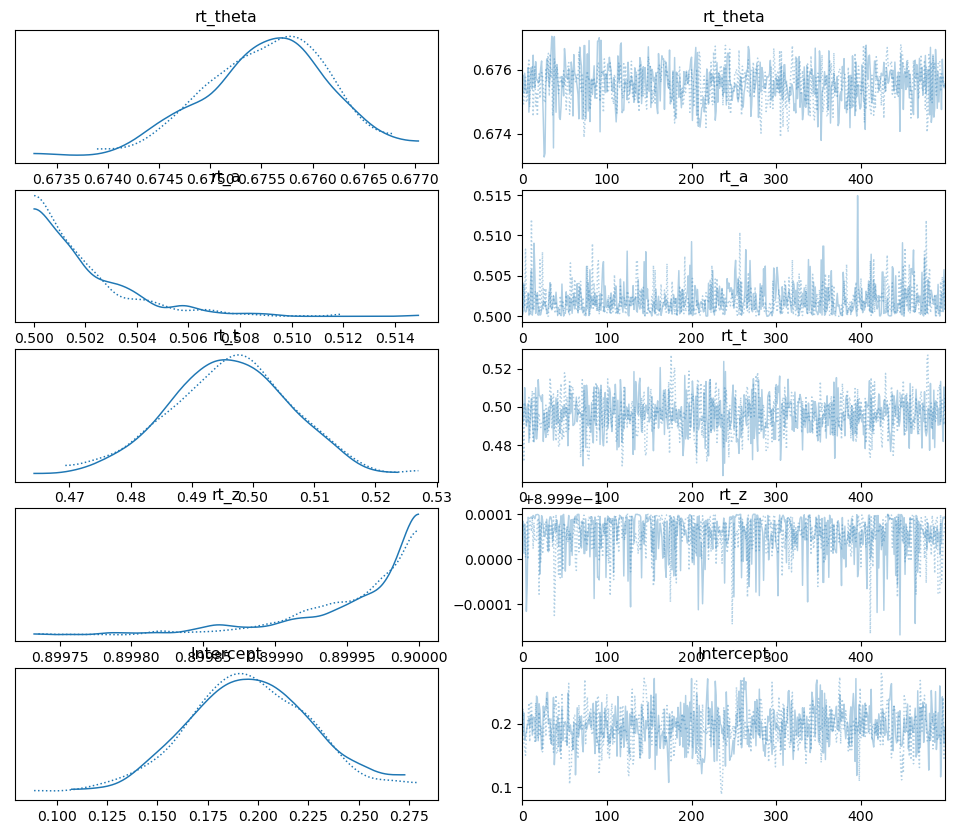

In [43]:
az.plot_trace(idata_bmb_ddm)

## Using the `LAN` factory class for LAN related functionalities

The LAN class has factory methods that produces LAN related log-likelihoods using either `aesara` or `jax` backend.


#### Create a LAN distribution directly from `WFPT.make_lan_distribution`

`WFPT.make_lan_distribution` conveniently wraps all steps above and create a `pymc.Distribution`.

In [31]:
LAN_jax = WFPT.make_ssm_distribution(
    model="test.onnx",
    backend="jax",
    list_params=["v", "a", "z", "t", "sv"],
)

In [32]:
LAN_jax.logp(np.ones((1000, 2)), *([1.0] * 5)).eval()

array(3887.7363, dtype=float32)

### LAN using the aesara backend

As an alternative, the onnx model can also be translated directly into aesara:

#### Create a LAN distribution directly from `WFPT.make_lan_distribution`

When `backend` is not set or to `"aesara"`, `WFPT.make_lan_distribution` will make a log-likelihood function with aesara and make a `pymc.Distribution` with aesara backend.

In [49]:
LAN_pytensor = WFPT.make_ssm_distribution(
    model="test.onnx",
    backend="pytensor",
    list_params=["v", "a", "z", "t", "sv"],
)

### Create arbitrary WFPT distributions

The `WFPT` factory class provides a general `make_distribution` class method to generate an arbitrary `pymc.Distribution` from user-supplied log-likelihood functions and `RandomVariable` `Op`s.

```python
arbitrary_distribution = WFPT.make_distribution(
    loglike=some_likelihood_func,
    rv=some_RandomVariable_Op,
    list_params=["v", "a", "z", "t", "theta"] # A list of str specifying the names and order of the parameters
)
```

## Sampling from arbitrary LAN distributions

The class produced by the factory classes can then be used for sampling with `PyMC`

#### Sampling with PyMC from LAN distribution with JAX backend

In [18]:
observed = np.column_stack([obs_angle["rts"][:, 0], obs_angle["choices"][:, 0]])
observed.shape

(1000, 2)

In [19]:
observed.reshape(-1, 2)

array([[ 1.50099075,  1.        ],
       [ 1.99701393, -1.        ],
       [ 2.46003556,  1.        ],
       ...,
       [ 2.55303359,  1.        ],
       [ 2.08701801,  1.        ],
       [ 0.93699789,  1.        ]])

In [44]:
LAN_Likelihood_jax = bmb.Likelihood(
    "WFPT", params=["v", "a", "z", "t", "sv"], parent="v", dist=LAN_jax
)
# You don't need to pass the link function for all the parameters when it's a non-distributional model.
# But if you want to use predictor for that parameter, you do need a link function
LAN_Family_jax = bmb.Family(
    "WFPT",
    likelihood=LAN_Likelihood_jax,
    link={
        "v": "identity",
        "a": "identity",
        "z": "identity",
        "t": "identity",
        "sv": "identity",
    },
)
priors = {
    "Intercept": bmb.Prior("Uniform", lower=-3, upper=3, initval=0),
    "a": bmb.Prior("Uniform", lower=0.5, upper=5, initval=2),
    "z": bmb.Prior("Uniform", lower=0.1, upper=0.9, initval=0.5),
    "t": bmb.Prior("Uniform", lower=0, upper=1.9, initval=0.01),
    "sv": bmb.Prior("Uniform", lower=0, upper=1.9, initval=0.01),
}
bmb_lan_jax = bmb.Model("rt ~ 1", df, family=LAN_Family_jax, priors=priors)
bmb_lan_jax

       Formula: rt ~ 1
        Family: WFPT
          Link: v = identity
  Observations: 1000
        Priors: 
    target = v
        Common-level effects
            Intercept ~ Uniform(lower: -3.0, upper: 3.0, initval: 0.0)
        
        Auxiliary parameters
            rt_a ~ Uniform(lower: 0.5, upper: 5.0, initval: 2.0)
            rt_t ~ Uniform(lower: 0.0, upper: 1.899999976158142, initval: 0.009999999776482582)
            rt_z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421, initval: 0.5)
            rt_sv ~ Uniform(lower: 0.0, upper: 1.899999976158142, initval: 0.009999999776482582)

In [45]:
pytensor.config.floatX = "float32"

jax_bmb_lan = bmb_lan_jax.fit(
    chains=2, draws=500, tune=500, mp_ctx=mp.get_context("fork")
)

array([[<AxesSubplot: title={'center': 'rt_a'}>,
        <AxesSubplot: title={'center': 'rt_a'}>],
       [<AxesSubplot: title={'center': 'rt_t'}>,
        <AxesSubplot: title={'center': 'rt_t'}>],
       [<AxesSubplot: title={'center': 'rt_z'}>,
        <AxesSubplot: title={'center': 'rt_z'}>],
       [<AxesSubplot: title={'center': 'rt_sv'}>,
        <AxesSubplot: title={'center': 'rt_sv'}>],
       [<AxesSubplot: title={'center': 'Intercept'}>,
        <AxesSubplot: title={'center': 'Intercept'}>]], dtype=object)

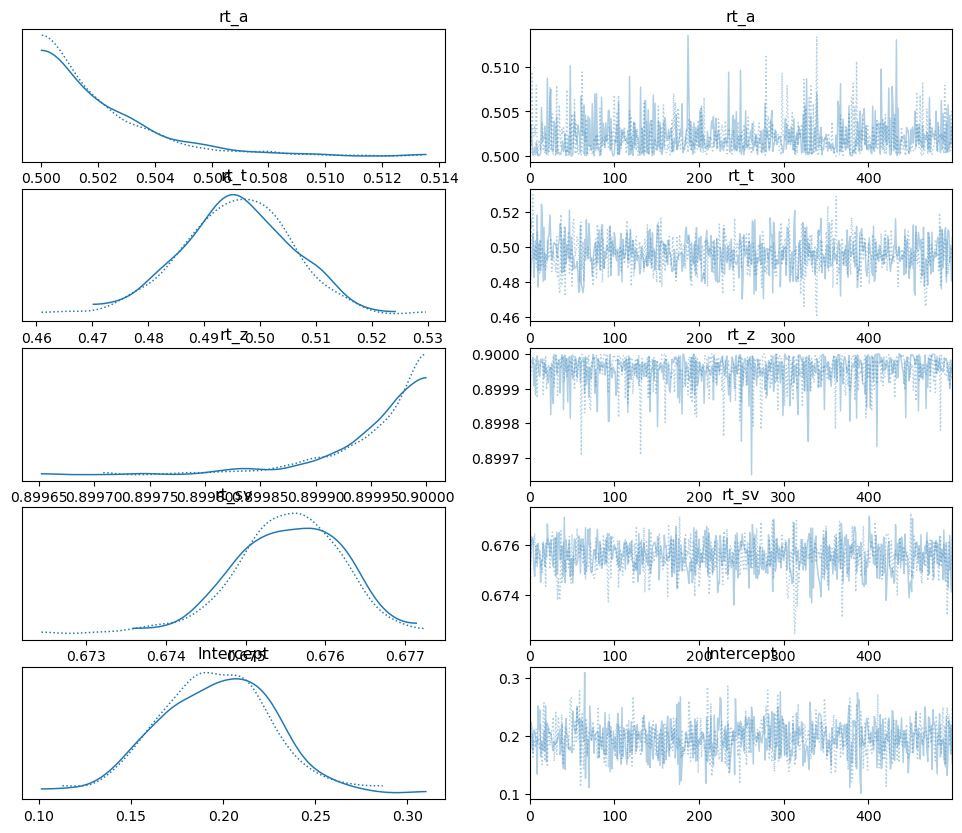

In [47]:
az.plot_trace(jax_bmb_lan)

#### Sampling with Pytensor from LAN distribution with pytensor backend

In [51]:
LAN_Likelihood_pytensor = bmb.Likelihood(
    "WFPT", params=["v", "a", "z", "t", "sv"], parent="v", dist=LAN_pytensor
)
# You don't need to pass the link function for all the parameters when it's a non-distributional model.
# But if you want to use predictor for that parameter, you do need a link function
LAN_Family_pytensor = bmb.Family(
    "WFPT",
    likelihood=LAN_Likelihood_pytensor,
    link={
        "v": "identity",
        "a": "identity",
        "z": "identity",
        "t": "identity",
        "sv": "identity",
    },
)
priors = {
    "Intercept": bmb.Prior("Uniform", lower=-3, upper=3, initval=0),
    "a": bmb.Prior("Uniform", lower=0.5, upper=5, initval=2),
    "z": bmb.Prior("Uniform", lower=0.1, upper=0.9, initval=0.5),
    "t": bmb.Prior("Uniform", lower=0, upper=1.9, initval=0.01),
    "sv": bmb.Prior("Uniform", lower=0, upper=1.9, initval=0.01),
}
bmb_lan_pytensor = bmb.Model("rt ~ 1", df, family=LAN_Family_pytensor, priors=priors)
bmb_lan_pytensor

       Formula: rt ~ 1
        Family: WFPT
          Link: v = identity
  Observations: 1000
        Priors: 
    target = v
        Common-level effects
            Intercept ~ Uniform(lower: -3.0, upper: 3.0, initval: 0.0)
        
        Auxiliary parameters
            rt_a ~ Uniform(lower: 0.5, upper: 5.0, initval: 2.0)
            rt_t ~ Uniform(lower: 0.0, upper: 1.899999976158142, initval: 0.009999999776482582)
            rt_z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421, initval: 0.5)
            rt_sv ~ Uniform(lower: 0.0, upper: 1.899999976158142, initval: 0.009999999776482582)

In [52]:
pytensor_bmb_lan = bmb_lan_pytensor.fit(
    chains=2, draws=500, tune=500, mp_ctx=mp.get_context("fork")
)

array([[<AxesSubplot: title={'center': 'rt_a'}>,
        <AxesSubplot: title={'center': 'rt_a'}>],
       [<AxesSubplot: title={'center': 'rt_t'}>,
        <AxesSubplot: title={'center': 'rt_t'}>],
       [<AxesSubplot: title={'center': 'rt_z'}>,
        <AxesSubplot: title={'center': 'rt_z'}>],
       [<AxesSubplot: title={'center': 'rt_sv'}>,
        <AxesSubplot: title={'center': 'rt_sv'}>],
       [<AxesSubplot: title={'center': 'Intercept'}>,
        <AxesSubplot: title={'center': 'Intercept'}>]], dtype=object)

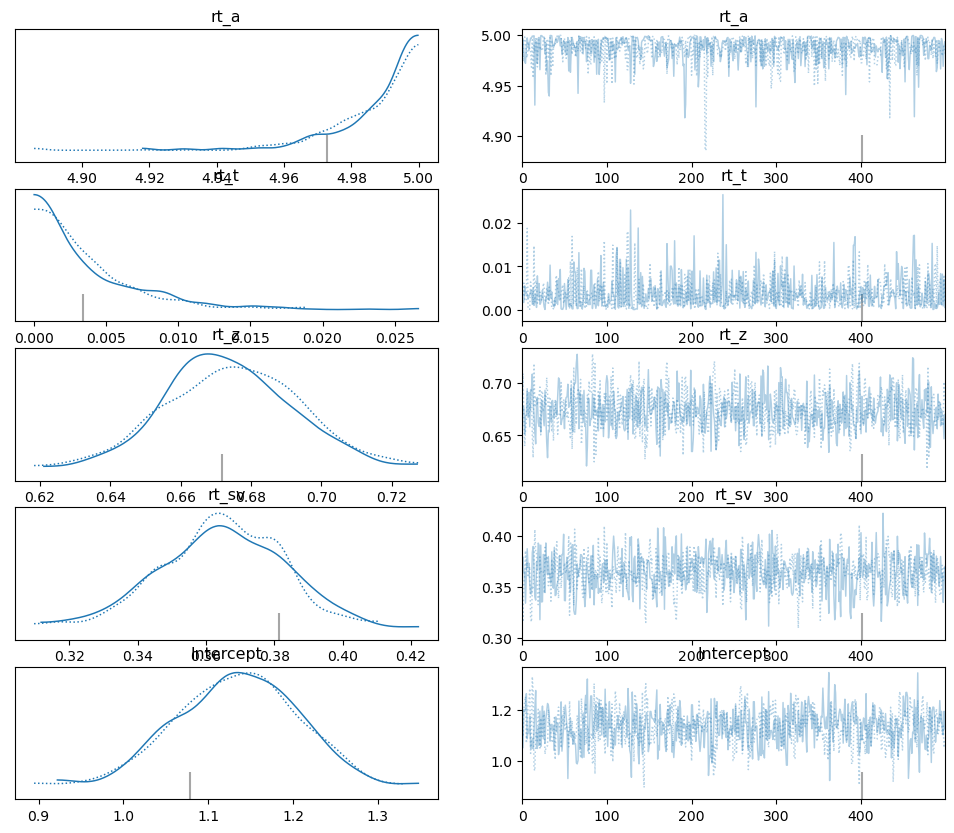

In [54]:
az.plot_trace(pytensor_bmb_lan)